Variables:

- flag superficie imputada
- 

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from malbecs.modeling import train as tr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler

import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42
wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


In [269]:

data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")


In [270]:
# wine_cols
# data['prod_he_shift1'].hist()

In [271]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
    "std_superficie_null"
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [272]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [
    c for c in eto_cols 
    if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c
]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]
tempuo = [c for c in eto_cols if ("Temp" in c) and ("StdM" in c )]
precipuo = [c for c in eto_cols if ("Precip" in c) and ("StdM" in c )]
snowpuo = [c for c in eto_cols if ("Snow" in c) and ("StdM" in c )]
winduo = [c for c in eto_cols if ("Wind" in c) and ("StdM" in c )]
gustuo = [c for c in eto_cols if ("Gust" in c) and ("StdM" in c)]

In [273]:
# data["std_superficie_null"].

In [285]:
def get_preprocesing_fase_nac():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',

        'prod_he_var_modo_zona_mean_shift1_total',
        "prod_he_var_modo_zona_change_total",
    ]

    return make_column_transformer(

        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['std_superficie_null']),

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),
        (mt.TargetEncoder(), ['id_zona']),
        
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),

        (StandardScaler(), model_num_cols),
        
        (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), temp_cols),
        
        (StandardScaler(),[c for c in precipuo if "2Std" in c]),

        (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
        #      [c for c in percip_cols if 'Sum' in c]
        # ),
        
        remainder='drop'
    )

In [286]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, VotingRegressor
import xgboost as xgb

# prep = get_preprocesing()
prep = get_preprocesing_fase_nac()

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=400,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
)


# model = xgb.XGBRegressor(
#     # tree_method="exact",
#     learning_rate=0.009261187281287938,
#     random_state = seed,
#     n_estimators = 840,
#     subsample=0.8,
#     colsample_bytree = 0.20,
#     colsample_bynode = 0.70,
#     # colsample_bylevel = 0.20,
#     max_depth=6,
#     # reg_alpha=100,
#     reg_lambda=15,
#     n_jobs=-1,
# )

# est_xgb = lambda i: xgb.XGBRegressor(
#     # tree_method="exact",
#     learning_rate=0.009261187281287938,
#     random_state=seed+i,
#     n_estimators=840,
#     subsample=0.8,
#     colsample_bytree=0.22,
#     colsample_bynode=0.70,
#     # colsample_bylevel = 0.20,
#     max_depth=6,
#     # reg_alpha=100,
#     reg_lambda=20,
#     n_jobs=-1,
# )

# est_rf = lambda i: RandomForestRegressor(
#     random_state=seed+i,
#     n_estimators=200,
#     min_samples_leaf=4,
#     n_jobs=-1,
#     max_features=0.2,
#     max_samples=0.8
# )

# model = VotingRegressor(
#     estimators=[(f"est_{i}", est_rf(i)) for i in range(5)],
# )

m = make_pipeline(
    prep,
    model
)

In [287]:
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "xgbregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


# base
# train:  [-4950.42915184 - 4769.7101927 - 4818.80517865]
# test:  [-4867.31956362 - 6767.87298344 - 5430.5269726]
# Train Mean RMSE: -4846.314841064502
# Test Mean RMSE: -5688.573173223823

# base x5
# train:  [-4942.37596943 -4743.90779478 -4821.93239258]
# test:  [-4843.45279828 -6753.29095468 -5374.1084608 ]
# Train Mean RMSE: -4836.072052262894
# Test Mean RMSE: -5656.9507379213055

train:  [-4681.62994936 -4413.92104217 -4456.46992562]
test:  [-4817.42778675 -6763.84335582 -5251.01670803]
Train Mean RMSE: -4517.340305718778
Test Mean RMSE: -5610.76261686473


In [244]:
from numpy import linspace
from sklearn.model_selection import GridSearchCV

param_grid = {
    
    # 'randomforestregressor__max_depth': [4, 5, 6, 8],
    # 'randomforestregressor__ccp_alpha': [0,0.01,0.02],

    'randomforestregressor__max_features': [0.17,0.18,0.2,],
    # 'randomforestregressor__max_samples': [0.8], 
    # 'randomforestregressor__min_samples_leaf':[4],
    'randomforestregressor__n_estimators': [180,185,190,195],

    # 'xgbregressor__max_features': [0.22],
    # 'xgbregressor__max_samples': [0.8],
    # 'xgbregressor__min_samples_leaf': [4],
    # 'xgbregressor__n_estimators': range(820,860,10),
    # 'xgbregressor__max_depth': [4,5,6,7],
    # 'xgbregressor__learning_rate': np.logspace(-2.07, -2, 5), #np.logspace(-2.07, -1.9, 10)
}

gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=tr.rmse_scorer
)

gsm.fit(X, y)

print(gsm.best_params_)
print(gsm.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'randomforestregressor__max_features': 0.17, 'randomforestregressor__n_estimators': 185}
-5599.154506461112


In [237]:
print(gsm.best_params_)
print(gsm.best_score_)

# {'xgbregressor__learning_rate': 0.009261187281287938}
# -5659.594296923198


{'randomforestregressor__max_features': 0.18, 'randomforestregressor__n_estimators': 185}
-5599.154506461112


In [245]:
# m = gsm.best_estimator_
# y_pred = m.fit(X_train, y_train).predict(X_test)
# score_model(X_test, y_test, y_pred, sup_norm=False)

res = cross_validate(
    estimator=gsm.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    # fit_params={
    #     "randomforestregressor__sample_weight": sample_weight
    # }
)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4784.36915135 -4548.96619055 -4575.62963877]
test:  [-4820.87332619 -6692.88229148 -5283.70790172]
Train Mean RMSE: -4636.321660221099
Test Mean RMSE: -5599.154506461112


# Comparativa Predicciones

In [258]:
# modelo final

est_rf = lambda i: RandomForestRegressor(
    random_state=seed+i,
    n_estimators=185,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.18,
    max_samples=0.8
)

model = VotingRegressor(
    estimators=[(f"est_{i}", est_rf(i)) for i in range(10)],
)
m_final = make_pipeline(
    prep,
    model
)
m_final.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['sup_is_nan']),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  ['id_zona']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['id_zona']),
                                                 ('ordinalencoder-3',
                                                  OrdinalEnc...
                                              RandomForestRegressor(max_features=0.18,
                                                                    max_samples=0.8,
                                                                    min_samples_leaf=4,
                                                                    n_estimators=185,
                                                                    n_jobs=-1,
                                                                    random_state=49)),
                                             ('est_8',
                                              RandomForestRegressor(max_features=0.18,
                                                                    max_samples=0.8,
                                                                    min_samples_leaf=4,
                                                                    n_estimators=185,
                                                                    n_jobs=-1,
                                                                    random_state=50)),
                                             ('est_9',
                                              RandomForestRegressor(max_features=0.18,
                                                                    max_samples=0.8,
                                                                    min_samples_leaf=4,
                                                                    n_estimators=185,
                                                                    n_jobs=-1,
                                                                    random_state=51))]))])

In [259]:
preds_final = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final['produccion'] = m_final.predict(X_final)
preds_final = preds_final.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

In [260]:
preds_fase_nac = pd.read_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None)
preds_fase_nac = preds_fase_nac[6]

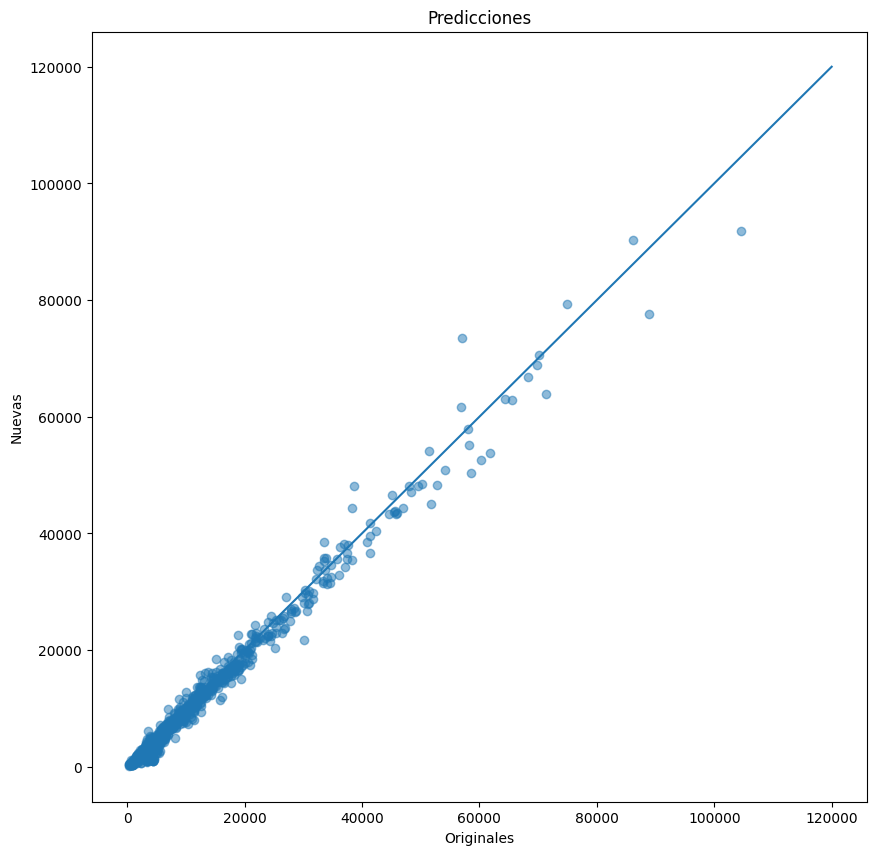

In [261]:
def compare_predictions(ref, comp):

    plt.figure(figsize=(10,10))
    plt.scatter(ref, comp, alpha=0.5)
    plt.plot( [0,120000],[0,120000] )
    plt.xlabel('Originales')
    plt.ylabel('Nuevas')
    plt.title('Predicciones')
    plt.show()

compare_predictions(preds_fase_nac,preds_final['produccion'] )